In [1]:
import matplotlib.pyplot as plt
import seaborn as sns   
from pathlib import Path
import pandas as pd
from optbinning import OptimalBinning, BinningProcess

Imports: core plotting, pathlib and data libraries. `optbinning` will be used for supervised binning and variable importance.
Ensure `optbinning` is installed and compatible with the environment.

#### IMPORTING DATA


Load raw dataset from `data/raw/heart.csv` using a reproducible project path.
Quick peek at the first rows to confirm column names and basic formatting.

In [2]:
ROOT = Path.cwd().parent
path_raw = ROOT / "data" / "raw" / "heart.csv"
df = pd.read_csv(path_raw)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Run `df.info()` to check data types and non-null counts. If no missing values are reported, proceed without imputation but verify domain-specific invalids.
If missing values are present, decide imputation or removal based on missingness mechanism and feature importance.

In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Show column-wise missing counts to decide per-feature treatment (drop, impute, or model-specific handling).

### SEE THE CLASS BALANCED


In [5]:
df["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

Check target distribution. If classes are balanced, standard stratification is fine; if imbalanced, consider resampling, class weights, or metrics like AUPRC/F1.

## SPLIT THE COLUMNS IN CATEGORICAL AND NUMERICAL

In [6]:
num_cols= df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols= df.select_dtypes(include=['object', 'category']).columns.tolist()

Automatically separate numerical and categorical features for tailored preprocessing and visualization. This ensures transformations are applied correctly.

In [7]:
import sys
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

Temporarily append project root to `sys.path` so `src` imports work in the notebook. For reproducibility consider installing the package or setting `PYTHONPATH`.
Avoid committing long-term path hacks in production scripts.

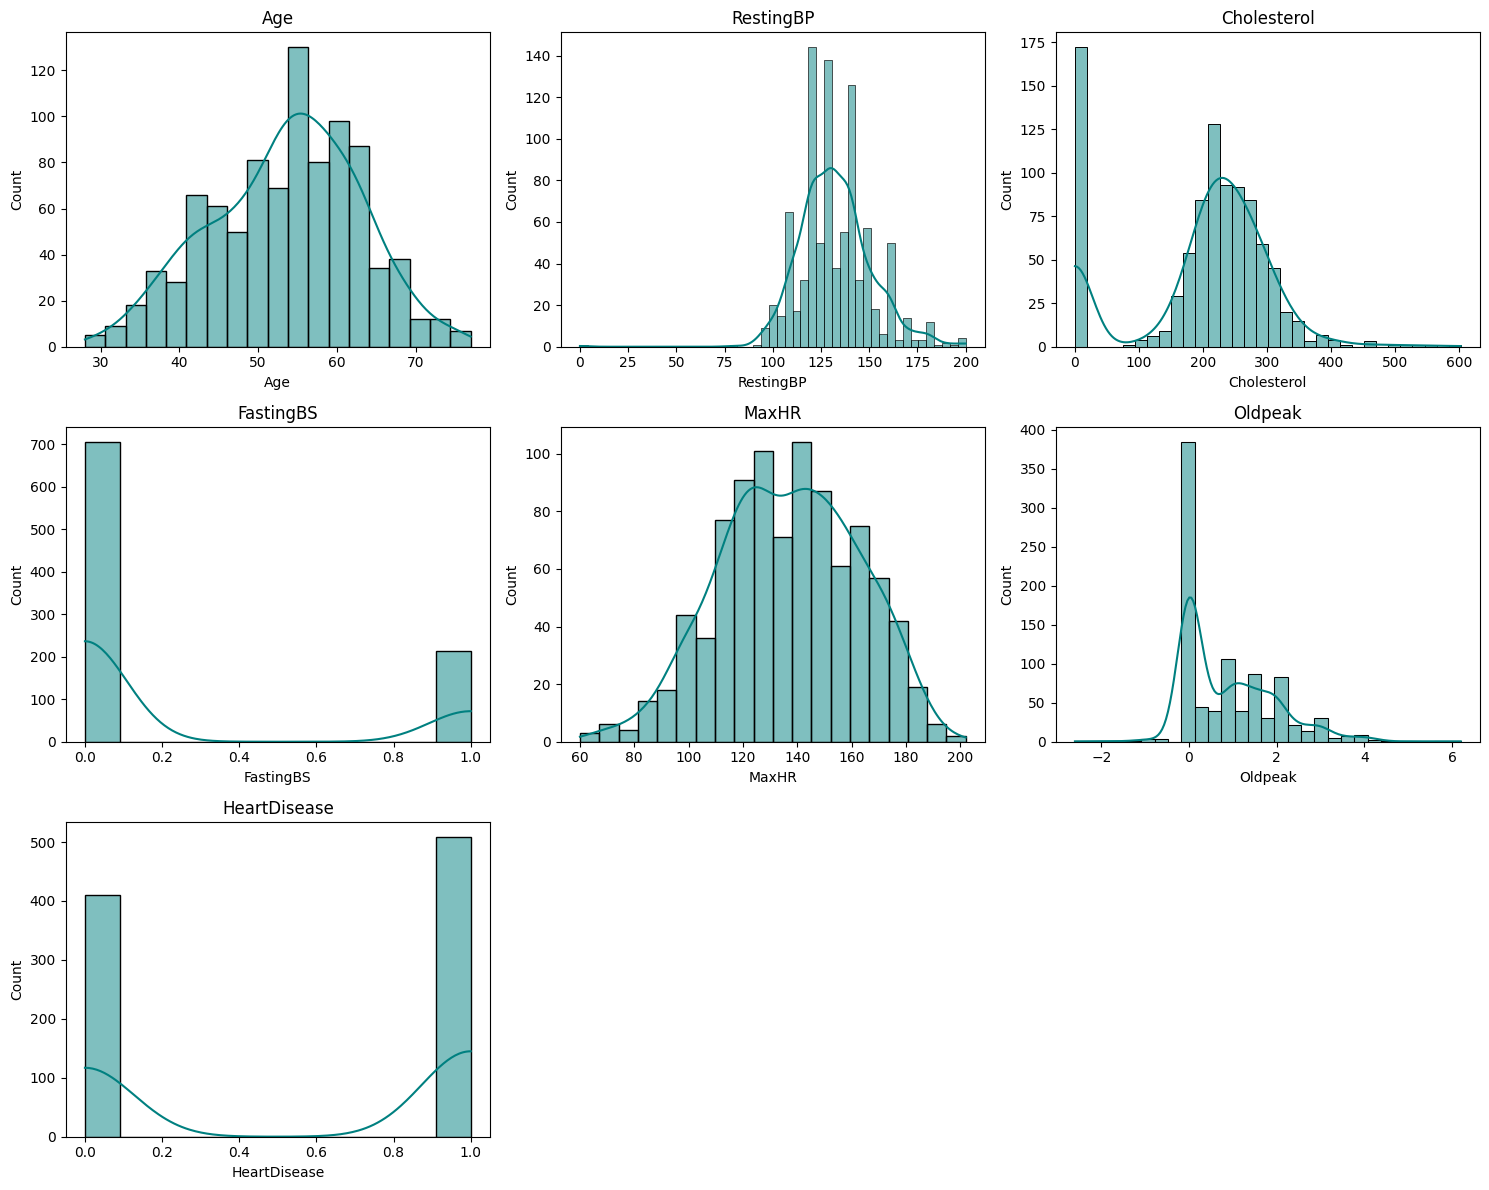

In [8]:
from src.visualizations import plot_simple_hist
plot_simple_hist(df, num_cols)

Plot histograms for numerical features to inspect distributions, skewness, and outliers. Note features that may need log transformation or winsorization.

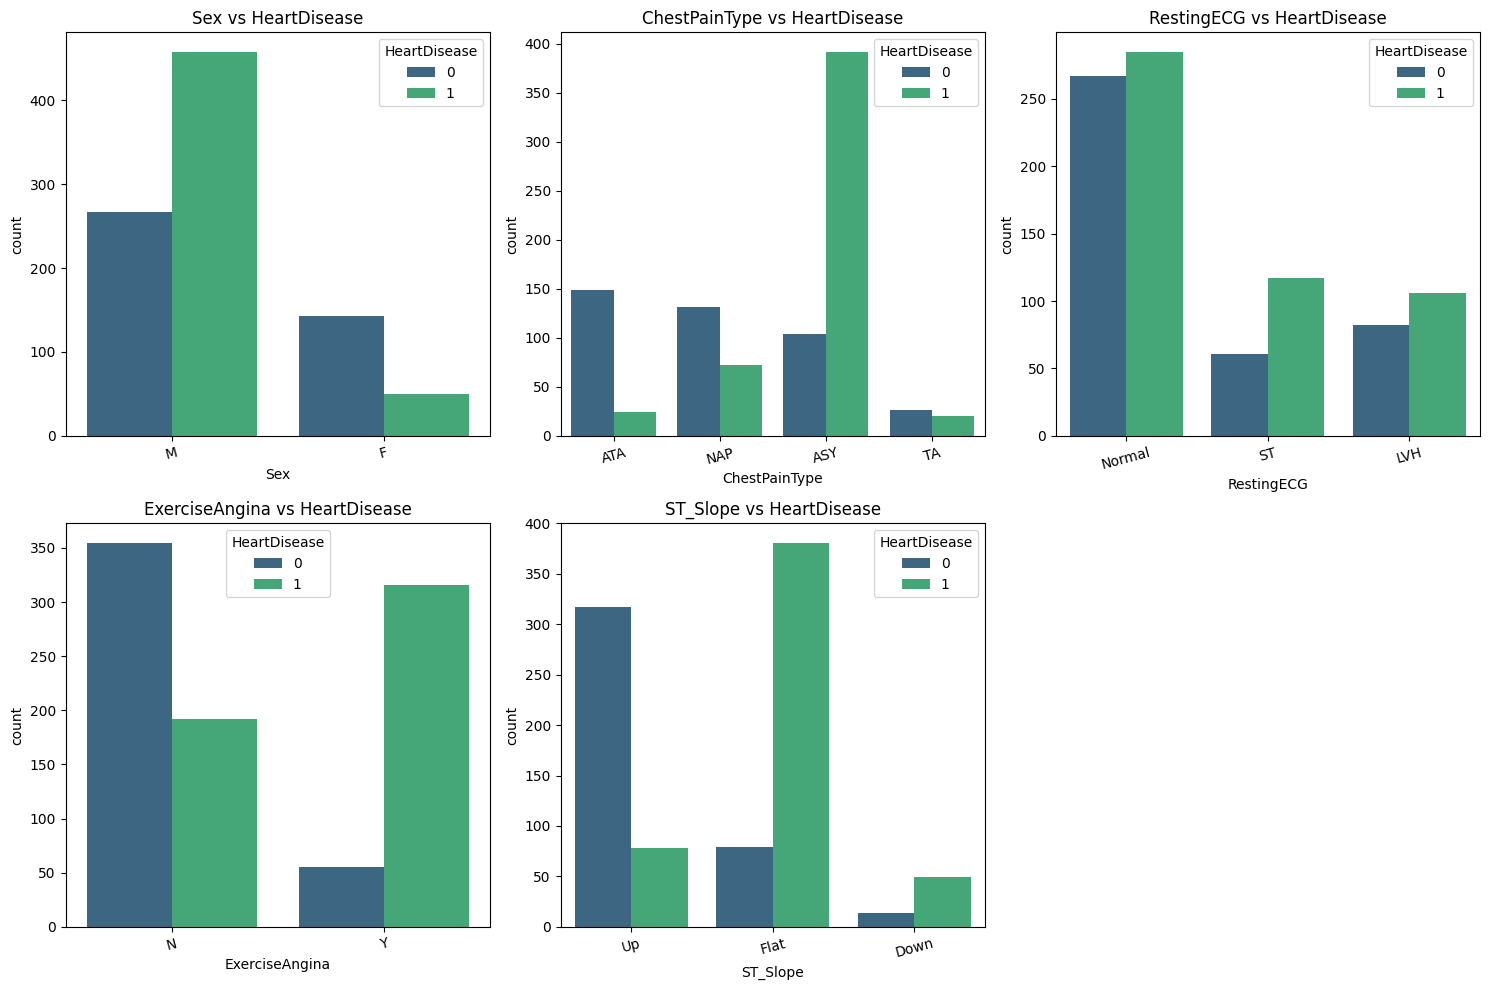

In [9]:
from src.visualizations import plot_categorical_vs_target
plot_categorical_vs_target(df, cat_cols, "HeartDisease")

Compare categorical feature distributions conditional on `HeartDisease` to identify strong predictors or unexpected category behavior. Flag categories with distinct event rates for encoding.

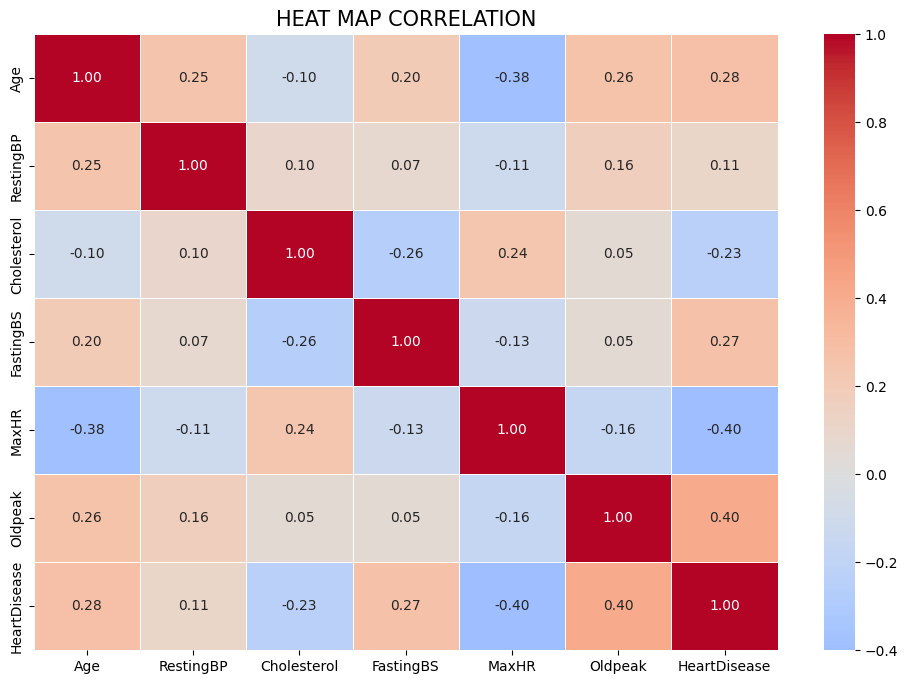

In [10]:
from src.visualizations import plot_correlation_heatmap
plot_correlation_heatmap(df, num_cols)

Display pairwise correlations among numerical features to detect multicollinearity and strong associations. Consider feature selection or regularization if high correlation is found.

### We are going to see and explore what numerical columns matters more to the target 

In [11]:
from src.visualizations import binningimportance
binningimportance(df, num_cols, "HeartDisease")


 Processing: Age
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 42.50)",135,0.147059,94,41,0.303704,1.044047,0.155103,0.018553
1,"[42.50, 45.50)",61,0.066449,41,20,0.327869,0.932164,0.056517,0.006819
2,"[45.50, 54.50)",275,0.299564,139,136,0.494545,0.236143,0.016839,0.002100
3,"[54.50, 56.50)",79,0.086057,30,49,0.620253,-0.276299,0.006434,0.000802
4,"[56.50, 59.50)",115,0.125272,38,77,0.669565,-0.491895,0.028969,0.003585
5,"[59.50, inf)",253,0.275599,68,185,0.731225,-0.786524,0.155983,0.019010
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,918,1.000000,410,508,0.553377,,0.419845,0.050869



 Total IV: 0.4198 - Strong predictor

 Processing: RestingBP
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 109.00)",54,0.058824,28,26,0.481481,0.288432,0.004936,0.000615
1,"[109.00, 121.00)",239,0.260349,122,117,0.489540,0.256171,0.017227,0.002147
2,"[121.00, 133.50)",227,0.247277,111,116,0.511013,0.170264,0.007217,0.000901
3,"[133.50, 140.50)",178,0.193900,79,99,0.556180,-0.011348,0.000025,0.000003
4,"[140.50, 157.00)",123,0.133987,42,81,0.658537,-0.442455,0.025224,0.003128
5,"[157.00, inf)",97,0.105664,28,69,0.711340,-0.687578,0.046435,0.005693
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,918,1.000000,410,508,0.553377,,0.101063,0.012487



 Total IV: 0.1011 - Medium predictor

 Processing: Cholesterol
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 124.50)",179,0.194989,22,157,0.877095,-1.750879,0.447169,0.049698
1,"[124.50, inf)",739,0.805011,388,351,0.474966,0.314543,0.080333,0.010000
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,918,1.000000,410,508,0.553377,,0.527502,0.059698



 Total IV: 0.5275 - Strong predictor

 Processing: FastingBS
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",704,0.766885,366,338,0.480114,0.293912,0.066815,0.008322
1,"[0.50, inf)",214,0.233115,44,170,0.794393,-1.137285,0.258537,0.030681
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,918,1.000000,410,508,0.553377,,0.325352,0.039003



 Total IV: 0.3254 - Strong predictor

 Processing: MaxHR
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 96.50)",52,0.056645,8,44,0.846154,-1.490424,0.100010,0.011459
1,"[96.50, 109.50)",73,0.079521,13,60,0.821918,-1.315071,0.113626,0.013261
2,"[109.50, 129.50)",236,0.257081,60,176,0.745763,-0.861815,0.172462,0.020914
3,"[129.50, 132.50)",51,0.055556,18,33,0.647059,-0.391812,0.008251,0.001025
4,"[132.50, 150.50)",228,0.248366,113,115,0.504386,0.19678,0.009688,0.001209
5,"[150.50, 159.50)",77,0.083878,46,31,0.402597,0.608978,0.031162,0.003836
6,"[159.50, 166.50)",75,0.081699,52,23,0.306667,1.030074,0.084006,0.010060
7,"[166.50, 177.50)",77,0.083878,57,20,0.259740,1.261643,0.125728,0.014750
8,"[177.50, inf)",49,0.053377,43,6,0.122449,2.183765,0.203237,0.021319
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000



 Total IV: 0.8482 - Strong predictor

 Processing: Oldpeak
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.25)",417,0.454248,275,142,0.340528,0.875268,0.342409,0.041485
1,"[0.25, 0.65)",55,0.059913,34,21,0.381818,0.696162,0.028952,0.003548
2,"[0.65, 1.05)",113,0.123094,37,76,0.672566,-0.505491,0.030007,0.003711
3,"[1.05, 1.45)",58,0.063181,17,41,0.706897,-0.666034,0.026139,0.003208
4,"[1.45, 1.65)",69,0.075163,19,50,0.724638,-0.75326,0.039233,0.004791
5,"[1.65, 2.45)",119,0.129630,22,97,0.815126,-1.269344,0.174264,0.020429
6,"[2.45, inf)",87,0.094771,6,81,0.931034,-2.388365,0.345870,0.035214
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,918,1.000000,410,508,0.553377,,0.986873,0.112387



 Total IV: 0.9869 - Strong predictor

 Processing: HeartDisease
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",918,1.0,410,508,0.553377,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,918,1.0,410,508,0.553377,,0.0,0.0



 Total IV: 0.0000 - Not useful


Run supervised binning and compute variable importance (IV) to rank numerical predictors. Features with low IV (e.g. <0.02) are weak predictors and candidates for removal.
Next steps: handle missing data, transform skewed features, encode categoricals, address class imbalance if present, and build a baseline model with stratified cross-validation.